# 4) Balance risk types

This notebook balances risk types (political, security and economic) in attempt to improve the model's ability to generalize by not creating any underrepresented risk types. The results don't appear to improve accuracy however, perhaps because we are dropping badly needed data.


## Read-in data

Seperate dataframes are imported for each language (Spanish & Portuguese).

In [1]:
import pandas as pd
import numpy as np

# imports the data with improved label quality
spanish_df = pd.read_csv('../Data/spanish_df.csv', encoding='utf-8')
portuguese_df = pd.read_csv('../Data/portuguese_df.csv', encoding='utf-8')

# imports put aside headlines
spanish_put_aside_df = pd.read_csv('../Data/spanish_put_aside_df.csv', encoding='utf-8')
portuguese_put_aside_df = pd.read_csv('../Data/portuguese_put_aside_df.csv', encoding='utf-8')

## Balance risk types

### Risk type breakdown

The risk types are not evenly distributed in either dataset, potentially leading to underrepresented risk types.

In [2]:
# prints and returns a dataframe of risk type counts and percentages
def risk_type_breakdown(df, title):
    print()
    print('*** ' + title + ' ***')
    counts = round(df.risk_type.value_counts() / 1000, 2)
    percent = round(((counts*1000) / len(df)) * 100, 2)
    risk_type_df = pd.DataFrame({'k': counts, '%': percent})
    print(risk_type_df)
    return risk_type_df

spanish_risk_type_breakdown = risk_type_breakdown(spanish_df, 'Main Spanish')
portuguese_risk_type_breakdown = risk_type_breakdown(portuguese_df, 'Main Portuguese')


*** Main Spanish ***
                        k      %
risk_type                       
security_violence    3.66  16.20
political_stability  2.60  11.51
economic_regulatory  2.26  10.00

*** Main Portuguese ***
                        k      %
risk_type                       
political_stability  1.33  20.83
economic_regulatory  0.87  13.63
security_violence    0.77  12.06


## Balance risk types

To balance the risk types, an equal sample of each is taken using the length of the most underrepresented type as the sample size.

In [3]:
import random

# randomly samples an equal number of each risk type
def balance_risk_types(df, breakdown):
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    risk_df = df.loc[~pd.isna(df.risk_type)]
    sample_no = int(min(breakdown.k) * 1000 - (len(df) * 0.01))
    
    risk_types = list(breakdown.index)
    sampled_headlines = []
    for risk in risk_types:
        population = list(df.loc[df.risk_type==risk].index)
        sample_indices = random.sample(population, sample_no)
        sampled_headlines.append(df.loc[df.index.isin(sample_indices)])
    
    return pd.concat([non_risk_df, pd.concat(sampled_headlines)]).reset_index(drop=True)

balanced_spanish_df = balance_risk_types(spanish_df, spanish_risk_type_breakdown)
balanced_portuguese_df = balance_risk_types(portuguese_df, portuguese_risk_type_breakdown)

## Train test split

Creates a train test split for a given dataframe.

In [4]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, test_size=0.3):
    X = df.headline
    y = [int(pd.notna(x)) for x in df.risk_type]
    return train_test_split(X, y, test_size=test_size, stratify=y)

## Fit model

A model is fit using TF-IDF vectors and logistic regression. A regression model is used to obtain probabilities so that the classification threshold can be easily varied.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# vectorizes data and fits a model 
def fit_model(df):
    X, y = df.headline, [int(pd.notna(x)) for x in df.risk_type]
    vectorizer = TfidfVectorizer()
    train_tfidf = vectorizer.fit_transform(X)
    model = LogisticRegression()
    model.fit(train_tfidf, y)
    return vectorizer, model

## Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [6]:
from sklearn.metrics import classification_report, accuracy_score

# evaluates the model's performance and prints the results
def evaluate_model(model, X_test_tfidf, y_test):
    y_pred = model.predict(X_test_tfidf)
    y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1] 
    classification_report_ = classification_report(y_test, y_pred)
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print("Classification Report:\n", classification_report_)
    print()
    return classification_report(y_test, y_pred, output_dict=True)

## Check results

A model is trained on the filtered dataset and evaluated on the set aside data. As we can see, the overall accuracy for risk headlines has imporved for both languages (see notebook 2), likely because the model is better able to distinguish between previously underrepresented risk types and non-risks.

In [7]:
# evaluates a filtered dataset against new headlines
def check_results(train_df, put_aside_df, language):
    print()
    print('*** ' + language + ' ***')
    print()

    X_train, X_test, y_train, y_test = split_data(train_df, test_size=0.01)
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    print(str(round(len(put_aside_df)/1000, 2)) + 'K put aside headlines')
    
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)
    y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]
    return evaluate_model(model, X_test_tfidf, y_test)

## Unbalanced headlines

Evaluates the results of unbalanced headlines.

In [8]:
# trains and evaluates a model on the unbalanced headlines data
unbalanced_spanish_classification_report_ = check_results(spanish_df, spanish_put_aside_df, language='Spanish')
unbalanced_portuguese_classification_report_ = check_results(portuguese_df, portuguese_put_aside_df, language='Portuguese')


*** Spanish ***

1.37K put aside headlines
Accuracy: 0.728
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.33      0.46       483
           1       0.72      0.95      0.82       891

    accuracy                           0.73      1374
   macro avg       0.74      0.64      0.64      1374
weighted avg       0.74      0.73      0.69      1374



*** Portuguese ***

0.54K put aside headlines
Accuracy: 0.705
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.42      0.54       219
           1       0.69      0.90      0.78       317

    accuracy                           0.71       536
   macro avg       0.72      0.66      0.66       536
weighted avg       0.72      0.71      0.68       536




## Balanced headlines

Evaluates the results of balanced headlines.

In [9]:
# trains and evaluates a model on the balanced headlines data
balanced_spanish_classification_report_ = check_results(balanced_spanish_df, spanish_put_aside_df, language='Spanish')
balanced_portuguese_classification_report_ = check_results(balanced_portuguese_df, portuguese_put_aside_df, language='Portuguese')


*** Spanish ***

1.37K put aside headlines
Accuracy: 0.723
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.37      0.48       483
           1       0.73      0.92      0.81       891

    accuracy                           0.72      1374
   macro avg       0.72      0.64      0.65      1374
weighted avg       0.72      0.72      0.70      1374



*** Portuguese ***

0.54K put aside headlines
Accuracy: 0.718
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.53      0.60       219
           1       0.72      0.85      0.78       317

    accuracy                           0.72       536
   macro avg       0.72      0.69      0.69       536
weighted avg       0.72      0.72      0.71       536




## Visualize results

Overall accuracy doesn't seem to have improved for neither the Spanish nor Portuguese headlines.

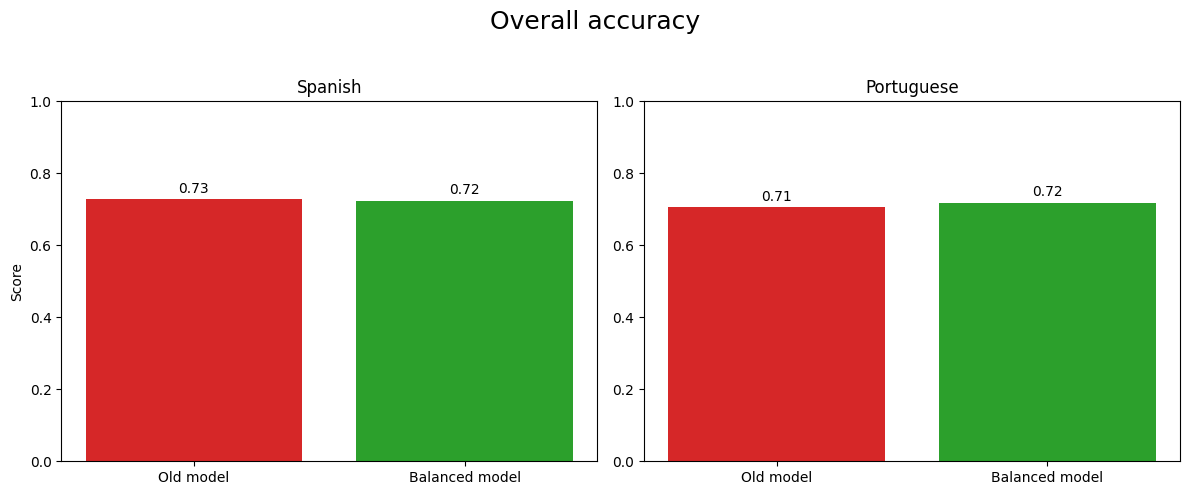

In [10]:
import matplotlib.pyplot as plt

# data
spanish_old_model = unbalanced_spanish_classification_report_['accuracy']
spanish_new_model = balanced_spanish_classification_report_['accuracy']
portuguese_old_model = unbalanced_portuguese_classification_report_['accuracy']
portuguese_new_model = balanced_portuguese_classification_report_['accuracy']

# labels for the statistics
labels = ['Spanish', 'Portuguese']
colors = ['tab:red', 'tab:green']

# data for the plots
old_model = [spanish_old_model, portuguese_old_model]
new_model = [spanish_new_model, portuguese_new_model]

# create subplots for comparison between languages and models
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot for Spanish
bars = axs[0].bar(['Old model', 'Balanced model'], [spanish_old_model, spanish_new_model], color=colors)
axs[0].set_title('Spanish')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot for Portuguese
bars = axs[1].bar(['Old model', 'Balanced model'], [portuguese_old_model, portuguese_new_model], color=colors)
axs[1].set_title('Portuguese')
axs[1].set_ylim(0, 1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title
fig.suptitle('Overall accuracy', fontsize=18)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/balance_risk_types_overall_accuracy.png', dpi=600, bbox_inches='tight')

# show the plot
plt.show()